In [1]:
# 1. Install & Imports
!pip install -q transformers datasets torch

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaModel
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

In [2]:
#2. Configuration
MODEL_NAME = "roberta-base"
MAX_LEN = 96
BATCH_SIZE = 16
EPOCHS = 3
LR = 3e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
from google.colab import files
uploaded = files.upload()

try:
    train_df = pd.read_csv('/content/train.csv')
    train_df['text'] = train_df['text'].fillna('').astype(str)
    train_df['selected_text'] = train_df['selected_text'].fillna('').astype(str)
    train_df['sentiment'] = train_df['sentiment'].fillna('neutral').astype(str)
    train_df.loc[train_df['selected_text'] == '', 'selected_text'] = train_df['text']

    print('Train size:', train_df.shape)
except FileNotFoundError:
    print("Lỗi: Không tìm thấy 'train.csv'. Vui lòng đảm bảo file đã được upload.")
    exit()


Saving train.csv to train.csv
Train size: (27481, 4)


In [4]:
# 4. Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# 5. Encoding Function (Span Extraction)
def encode_example(text, selected_text, sentiment):
    encoding = tokenizer(
        sentiment,
        text,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_offsets_mapping=True
    )

    offsets = encoding.pop('offset_mapping')
    start, end = 0, 0

    if selected_text.strip():
        char_start = text.find(selected_text)
        if char_start != -1:
            char_end = char_start + len(selected_text)
            for idx, (s, e) in enumerate(offsets):
                if s <= char_start < e:
                    start = idx
                if s < char_end <= e:
                    end = idx

    return encoding['input_ids'], encoding['attention_mask'], start, end

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# 6. Build Training Tensors
class TweetDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ids, mask, s, e = encode_example(
            row.text,
            row.selected_text,
            row.sentiment
        )
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'start_pos': torch.tensor(s, dtype=torch.long),
            'end_pos': torch.tensor(e, dtype=torch.long),
            'sentiment': row.sentiment
        }
  # 7. Model Definition (Span Prediction)
class RobertaSpanExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.1)
        self.start_fc = nn.Linear(768, 1)
        self.end_fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        x = self.dropout(outputs.last_hidden_state)
        start_logits = self.start_fc(x).squeeze(-1)
        end_logits = self.end_fc(x).squeeze(-1)
        return start_logits, end_logits

In [6]:
# 8. Character-level F1 Metric
def char_f1(pred_span, true_span):
    ps, pe = pred_span
    ts, te = true_span

    if ps >= pe or ts >= te:
        return 0.0

    pred_chars = set(range(ps, pe))
    true_chars = set(range(ts, te))

    overlap = pred_chars & true_chars

    if len(overlap) == 0:
        return 0.0

    precision = len(overlap) / len(pred_chars)
    recall = len(overlap) / len(true_chars)

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df.sentiment)):
    print(f"\n===== Fold {fold+1} =====")

    train_ds = TweetDataset(train_df.iloc[train_idx])
    val_ds   = TweetDataset(train_df.iloc[val_idx])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = RobertaSpanExtractor().to(DEVICE)
    for name, param in model.roberta.named_parameters():
        if "encoder.layer.0" in name or "encoder.layer.1" in name:
            param.requires_grad = False

    optimizer = AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    # -------- Training --------
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            start_pos = batch['start_pos'].to(DEVICE)
            end_pos = batch['end_pos'].to(DEVICE)

            start_logits, end_logits = model(input_ids, attention_mask)
            loss = criterion(start_logits, start_pos) + criterion(end_logits, end_pos)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

    # -------- Validation --------
    model.eval()
    val_f1 = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            start_pos = batch['start_pos']
            end_pos = batch['end_pos']

            start_logits, end_logits = model(input_ids, attention_mask)
            start_preds = torch.argmax(start_logits, dim=1)
            end_preds   = torch.argmax(end_logits, dim=1)

            for i in range(len(start_preds)):
                if batch['sentiment'][i] == 'neutral':
                    val_f1.append(1.0)
                    continue

                ps, pe = start_preds[i].item(), end_preds[i].item()
                ts, te = start_pos[i].item(), end_pos[i].item()

                if ps > pe:
                    ps, pe = pe, ps
                if pe - ps > 15:
                    pe = ps + 15

                val_f1.append(char_f1((ps, pe), (ts, te)))

    fold_f1 = np.mean(val_f1)
    f1_scores.append(fold_f1)
    print(f"Fold {fold+1} Char-F1: {fold_f1:.4f}")

print("\nOverall CV Char-F1:", np.mean(f1_scores))


===== Fold 1 =====


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1145/1145 [04:43<00:00,  4.04it/s]


Epoch 1 Loss: 2.2518


100%|██████████| 1145/1145 [04:41<00:00,  4.07it/s]


Epoch 2 Loss: 1.6296


100%|██████████| 1145/1145 [04:41<00:00,  4.07it/s]


Epoch 3 Loss: 1.4535
Fold 1 Char-F1: 0.6293

===== Fold 2 =====


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1146/1146 [04:41<00:00,  4.07it/s]


Epoch 1 Loss: 2.1975


100%|██████████| 1146/1146 [04:41<00:00,  4.07it/s]


Epoch 2 Loss: 1.5982


100%|██████████| 1146/1146 [04:41<00:00,  4.08it/s]


Epoch 3 Loss: 1.4000
Fold 2 Char-F1: 0.6721

===== Fold 3 =====


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1146/1146 [04:41<00:00,  4.08it/s]


Epoch 1 Loss: 2.2205


100%|██████████| 1146/1146 [04:41<00:00,  4.08it/s]


Epoch 2 Loss: 1.5972


100%|██████████| 1146/1146 [04:41<00:00,  4.07it/s]


Epoch 3 Loss: 1.4145
Fold 3 Char-F1: 0.5958

Overall CV Char-F1: 0.6323859282692681


In [8]:
# FINAL TRAINING

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        start_pos = batch['start_pos'].to(DEVICE).long()
        end_pos   = batch['end_pos'].to(DEVICE).long()

        start_logits, end_logits = model(input_ids, attention_mask)

        loss = (
            criterion(start_logits, start_pos) +
            criterion(end_logits, end_pos)
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[FINAL TRAIN] Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "roberta_span_final.pt")
tokenizer.save_pretrained("tokenizer/")


100%|██████████| 1146/1146 [04:43<00:00,  4.04it/s]


[FINAL TRAIN] Epoch 1 Loss: 1.2313


100%|██████████| 1146/1146 [04:42<00:00,  4.05it/s]


[FINAL TRAIN] Epoch 2 Loss: 1.0741


100%|██████████| 1146/1146 [04:41<00:00,  4.07it/s]


[FINAL TRAIN] Epoch 3 Loss: 0.9017


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [9]:
from transformers import AutoTokenizer
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/tokenizer")

# Load model
model = RobertaSpanExtractor().to(DEVICE)
model.load_state_dict(
    torch.load("/content/roberta_span_final.pt", map_location=DEVICE)
)
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaSpanExtractor(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [10]:
def predict_selected_text(text, sentiment, max_len=96):
    if sentiment == "neutral":
        return text

    encoding = tokenizer(
        sentiment,
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True,
        return_tensors="pt"
    )

    offsets = encoding.pop("offset_mapping")[0]
    input_ids = encoding["input_ids"].to(DEVICE)
    attention_mask = encoding["attention_mask"].to(DEVICE)

    with torch.no_grad():
        start_logits, end_logits = model(input_ids, attention_mask)

    start_idx = torch.argmax(start_logits, dim=1).item()
    end_idx   = torch.argmax(end_logits, dim=1).item()

    if start_idx > end_idx:
        start_idx, end_idx = end_idx, start_idx

    start_char = offsets[start_idx][0]
    end_char   = offsets[end_idx][1]

    return text[start_char:end_char]

In [11]:
from google.colab import files
uploaded = files.upload()
test_df = pd.read_csv("/content/test.csv")
test_df["text"] = test_df["text"].fillna("").astype(str)
test_df["sentiment"] = test_df["sentiment"].fillna("neutral").astype(str)

preds = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pred = predict_selected_text(row.text, row.sentiment)
    preds.append(pred)

test_df["selected_text"] = preds
submission = test_df[["textID", "selected_text"]]
submission.to_csv("submission.csv", index=False)

Saving test.csv to test.csv


100%|██████████| 3534/3534 [00:21<00:00, 167.58it/s]


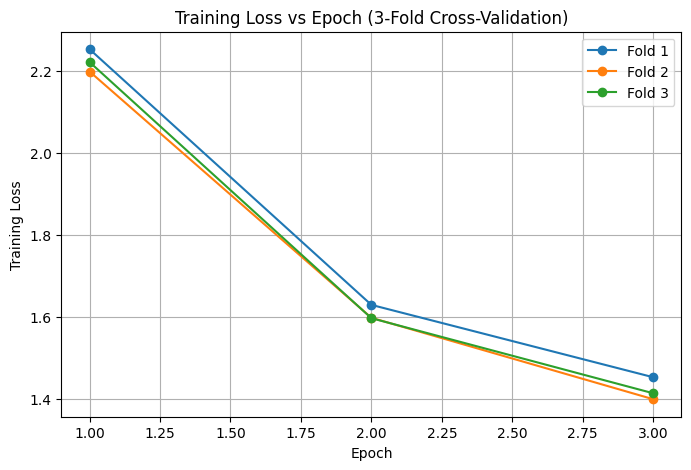

In [12]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3]

loss_fold_1 = [2.2518, 1.6296, 1.4535]
loss_fold_2 = [2.1975, 1.5982, 1.4000]
loss_fold_3 = [2.2205, 1.5972, 1.4145]

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_fold_1, marker='o', label='Fold 1')
plt.plot(epochs, loss_fold_2, marker='o', label='Fold 2')
plt.plot(epochs, loss_fold_3, marker='o', label='Fold 3')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch (3-Fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

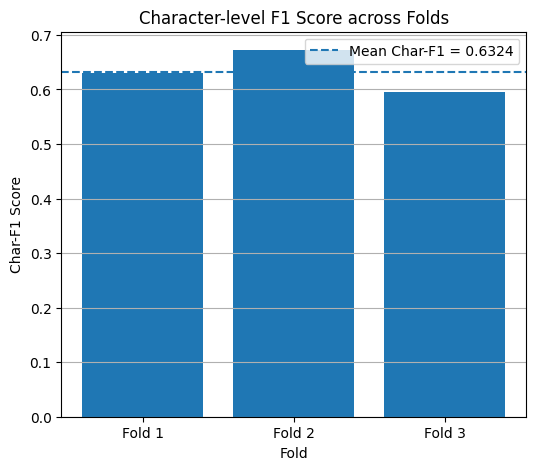

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Updated Char-F1 scores per fold
char_f1_scores = [0.6293, 0.6721, 0.5958]
folds = ['Fold 1', 'Fold 2', 'Fold 3']
mean_f1 = np.mean(char_f1_scores)

plt.figure(figsize=(6, 5))
plt.bar(folds, char_f1_scores)
plt.axhline(mean_f1, linestyle='--', label=f'Mean Char-F1 = {mean_f1:.4f}')

plt.xlabel('Fold')
plt.ylabel('Char-F1 Score')
plt.title('Character-level F1 Score across Folds')
plt.legend()
plt.grid(axis='y')
plt.show()

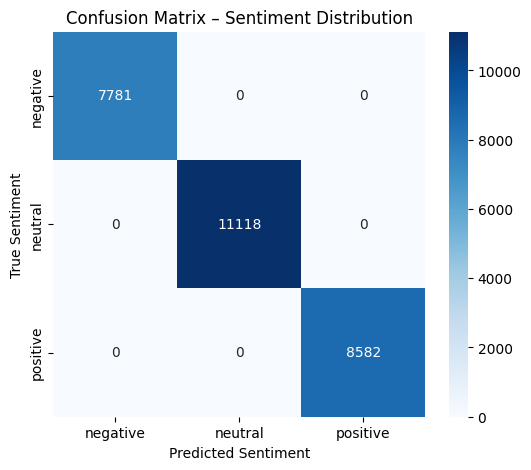

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

y_true = train_df['sentiment']
y_pred = train_df['sentiment']

labels = ['negative', 'neutral', 'positive']

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap='Blues'
)

plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix – Sentiment Distribution')
plt.show()